<a href="https://colab.research.google.com/github/quanslack/PaDiM-Anomaly-Detection-Localization-master/blob/main/yolo_vehicle_number_plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import os
import gc
import shutil
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
from glob import glob
import xml.etree.ElementTree as xet
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

# GPU
import torch
from numba import cuda

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'tanmaysharma77'
os.environ['KAGGLE_KEY'] = 'c6402846aded9e94a3782f289d927cd6'

In [ ]:
!kaggle datasets download -d saisirishan/indian-vehicle-dataset

Dataset URL: https://www.kaggle.com/datasets/saisirishan/indian-vehicle-dataset
License(s): unknown
 98% 175M/178M [00:05<00:00, 37.2MB/s]
100% 178M/178M [00:05<00:00, 34.9MB/s]


In [ ]:
!unzip indian-vehicle-dataset.zip

Archive:  indian-vehicle-dataset.zip
  inflating: State-wise_OLX/AN/AN1.jpg  
  inflating: State-wise_OLX/AN/AN1.xml  
  inflating: State-wise_OLX/AN/AN10.jpg  
  inflating: State-wise_OLX/AN/AN10.xml  
  inflating: State-wise_OLX/AN/AN2.jpg  
  inflating: State-wise_OLX/AN/AN2.xml  
  inflating: State-wise_OLX/AN/AN4.jpg  
  inflating: State-wise_OLX/AN/AN4.xml  
  inflating: State-wise_OLX/AN/AN5.jpg  
  inflating: State-wise_OLX/AN/AN5.xml  
  inflating: State-wise_OLX/AN/AN6.jpg  
  inflating: State-wise_OLX/AN/AN6.xml  
  inflating: State-wise_OLX/AN/AN7.jpg  
  inflating: State-wise_OLX/AN/AN7.xml  
  inflating: State-wise_OLX/AP/AP1.jpg  
  inflating: State-wise_OLX/AP/AP1.xml  
  inflating: State-wise_OLX/AP/AP10.jpg  
  inflating: State-wise_OLX/AP/AP10.xml  
  inflating: State-wise_OLX/AP/AP12.jpg  
  inflating: State-wise_OLX/AP/AP12.xml  
  inflating: State-wise_OLX/AP/AP13.jpg  
  inflating: State-wise_OLX/AP/AP13.xml  
  inflating: State-wise_OLX/AP/AP14.jpg  
  inflating

In [ ]:
path = glob('/content/google_images/*.xml')
print(len(path))


labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['plate_number'].append(plate_number)

440


In [ ]:


new_paths = glob('/content/State-wise_OLX/*/*.xml')
print(len(new_paths))


new_labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in new_paths:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    new_labels_dict['filepath'].append(filename)
    new_labels_dict['xmin'].append(xmin)
    new_labels_dict['xmax'].append(xmax)
    new_labels_dict['ymin'].append(ymin)
    new_labels_dict['ymax'].append(ymax)
    new_labels_dict['plate_number'].append(plate_number)



603


In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/content/google_images/b78553c7-977e-49a2-b3d2...,56,220,199,276,KL01KL0KL01
1,/content/google_images/car-wbs-KA04MN3622_0000...,197,370,375,413,KA04MN3622
2,/content/google_images/car-wbs-MH20BN3525_0000...,163,364,238,284,MH20BN3525
3,/content/google_images/d5ddd1e6-56ca-4991-994e...,451,592,343,391,RJ27TC0530
4,/content/google_images/car-wbs-KL10AW2111_0000...,186,336,189,228,KL10AW2111


In [ ]:
new_df = pd.DataFrame(new_labels_dict)
new_df.to_csv('new_labels.csv',index=False)
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/content/State-wise_OLX/DL/DL12.xml,101,185,229,251,DL5CH7599
1,/content/State-wise_OLX/DL/DL24.xml,94,178,237,253,DL3CCK8019
2,/content/State-wise_OLX/DL/DL26.xml,90,193,285,308,DL11CA4900
3,/content/State-wise_OLX/DL/DL15.xml,164,226,162,189,DL8CZ7230
4,/content/State-wise_OLX/DL/DL8.xml,118,176,147,161,DL10CH1252


In [ ]:
 #parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/google_images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height

df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/content/google_images/b78553c7-977e-49a2-b3d2...,56,220,199,276,KL01KL0KL01,/content/google_images/b78553c7-977e-49a2-b3d2...,500,399
1,/content/google_images/car-wbs-KA04MN3622_0000...,197,370,375,413,KA04MN3622,/content/google_images/car-wbs-KA04MN3622_0000...,552,552
2,/content/google_images/car-wbs-MH20BN3525_0000...,163,364,238,284,MH20BN3525,/content/google_images/car-wbs-MH20BN3525_0000...,437,354
3,/content/google_images/d5ddd1e6-56ca-4991-994e...,451,592,343,391,RJ27TC0530,/content/google_images/d5ddd1e6-56ca-4991-994e...,1024,683
4,/content/google_images/car-wbs-KL10AW2111_0000...,186,336,189,228,KL10AW2111,/content/google_images/car-wbs-KL10AW2111_0000...,450,397


In [ ]:
# parsing
def newparsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/State-wise_OLX/{name[:2]}/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height

new_df[['filename','width','height']] = new_df['filepath'].apply(newparsing).apply(pd.Series)
new_df.head()



,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/content/State-wise_OLX/DL/DL12.xml,101,185,229,251,DL5CH7599,/content/State-wise_OLX/DL/DL12.jpg,272,363
1,/content/State-wise_OLX/DL/DL24.xml,94,178,237,253,DL3CCK8019,/content/State-wise_OLX/DL/DL24.jpg,272,363
2,/content/State-wise_OLX/DL/DL26.xml,90,193,285,308,DL11CA4900,/content/State-wise_OLX/DL/DL26.jpg,272,363
3,/content/State-wise_OLX/DL/DL15.xml,164,226,162,189,DL8CZ7230,/content/State-wise_OLX/DL/DL15.jpg,272,292
4,/content/State-wise_OLX/DL/DL8.xml,118,176,147,161,DL10CH1252,/content/State-wise_OLX/DL/DL8.jpg,272,204


In [ ]:


# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()



,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/google_images/b78553c7-977e-49a2-b3d2...,56,220,199,276,KL01KL0KL01,/content/google_images/b78553c7-977e-49a2-b3d2...,500,399,0.276000,0.595238,0.328000,0.192982
1,/content/google_images/car-wbs-KA04MN3622_0000...,197,370,375,413,KA04MN3622,/content/google_images/car-wbs-KA04MN3622_0000...,552,552,0.513587,0.713768,0.313406,0.068841
2,/content/google_images/car-wbs-MH20BN3525_0000...,163,364,238,284,MH20BN3525,/content/google_images/car-wbs-MH20BN3525_0000...,437,354,0.602975,0.737288,0.459954,0.129944
3,/content/google_images/d5ddd1e6-56ca-4991-994e...,451,592,343,391,RJ27TC0530,/content/google_images/d5ddd1e6-56ca-4991-994e...,1024,683,0.509277,0.537335,0.137695,0.070278
4,/content/google_images/car-wbs-KL10AW2111_0000...,186,336,189,228,KL10AW2111,/content/google_images/car-wbs-KL10AW2111_0000...,450,397,0.580000,0.525189,0.333333,0.098237


In [ ]:
# center_x, center_y, width , height
new_df['center_x'] = (new_df['xmax'] + new_df['xmin'])/(2*new_df['width'])
new_df['center_y'] = (new_df['ymax'] + new_df['ymin'])/(2*new_df['height'])

new_df['bb_width'] = (new_df['xmax'] - new_df['xmin'])/new_df['width']
new_df['bb_height'] = (new_df['ymax'] - new_df['ymin'])/new_df['height']
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/State-wise_OLX/DL/DL12.xml,101,185,229,251,DL5CH7599,/content/State-wise_OLX/DL/DL12.jpg,272,363,0.525735,0.661157,0.308824,0.060606
1,/content/State-wise_OLX/DL/DL24.xml,94,178,237,253,DL3CCK8019,/content/State-wise_OLX/DL/DL24.jpg,272,363,0.500000,0.674931,0.308824,0.044077
2,/content/State-wise_OLX/DL/DL26.xml,90,193,285,308,DL11CA4900,/content/State-wise_OLX/DL/DL26.jpg,272,363,0.520221,0.816804,0.378676,0.063361
3,/content/State-wise_OLX/DL/DL15.xml,164,226,162,189,DL8CZ7230,/content/State-wise_OLX/DL/DL15.jpg,272,292,0.716912,0.601027,0.227941,0.092466
4,/content/State-wise_OLX/DL/DL8.xml,118,176,147,161,DL10CH1252,/content/State-wise_OLX/DL/DL8.jpg,272,204,0.540441,0.754902,0.213235,0.068627


In [ ]:
data = pd.concat([df,new_df]).sample(frac=1).reset_index(drop=True)
data.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/State-wise_OLX/JK/JK24.xml,105,179,242,257,JK02BN3088,/content/State-wise_OLX/JK/JK24.jpg,272,363,0.522059,0.687328,0.272059,0.041322
1,/content/State-wise_OLX/UP/UP1.xml,100,197,170,197,UP57H8173,/content/State-wise_OLX/UP/UP1.jpg,272,363,0.545956,0.505510,0.356618,0.074380
2,/content/State-wise_OLX/GJ/GJ14.xml,100,171,151,165,GJ06DG9355,/content/State-wise_OLX/GJ/GJ14.jpg,272,204,0.498162,0.774510,0.261029,0.068627
3,/content/State-wise_OLX/BR/BR8.xml,99,161,132,145,BR01DG6692,/content/State-wise_OLX/BR/BR8.jpg,272,153,0.477941,0.905229,0.227941,0.084967
4,/content/State-wise_OLX/OD/OD25.xml,89,184,279,297,OD02AP3010,/content/State-wise_OLX/OD/OD25.jpg,272,363,0.501838,0.793388,0.349265,0.049587


In [ ]:


df_metadata = pd.DataFrame()
df_metadata = data.rename(columns={"filename": "image_path"})
df_metadata.head()

# Extract individual bbox coordinates
df_metadata["x1_bbox"] = df_metadata["xmin"]
df_metadata["y1_bbox"] = df_metadata["ymin"]
df_metadata["x2_bbox"] = df_metadata["xmax"]
df_metadata["y2_bbox"] = df_metadata["ymax"]
df_metadata["xmid"] = df_metadata["center_x"]
df_metadata["ymid"] = df_metadata["center_y"]
df_metadata = df_metadata.drop(columns=["filepath", "xmin", "xmax", "ymin", "ymax", "width", "height", "center_x", "center_y"])
df_metadata.head()



,plate_number,image_path,bb_width,bb_height,x1_bbox,y1_bbox,x2_bbox,y2_bbox,xmid,ymid
0,JK02BN3088,/content/State-wise_OLX/JK/JK24.jpg,0.272059,0.041322,105,242,179,257,0.522059,0.687328
1,UP57H8173,/content/State-wise_OLX/UP/UP1.jpg,0.356618,0.074380,100,170,197,197,0.545956,0.505510
2,GJ06DG9355,/content/State-wise_OLX/GJ/GJ14.jpg,0.261029,0.068627,100,151,171,165,0.498162,0.774510
3,BR01DG6692,/content/State-wise_OLX/BR/BR8.jpg,0.227941,0.084967,99,132,161,145,0.477941,0.905229
4,OD02AP3010,/content/State-wise_OLX/OD/OD25.jpg,0.349265,0.049587,89,279,184,297,0.501838,0.793388


In [ ]:


### split the data into train and test
df_train = data.iloc[:800]
df_test = data.iloc[850:]
df_val = data.iloc[800:850]



In [ ]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics
!pip install -U ray[tune]



Cloning into 'ultralytics'...
remote: Enumerating objects: 30118, done.
remote: Counting objects: 100% (564/564), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 30118 (delta 317), reused 317 (delta 145), pack-reused 29554
Receiving objects: 100% (30118/30118), 15.47 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (21650/21650), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.9/802.9 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.

In [ ]:


!mkdir "ultralytics/datasets"
!mkdir "ultralytics/datasets/train"
!mkdir "ultralytics/datasets/val"
!mkdir "ultralytics/datasets/test"



In [ ]:
yaml_file_path = 'ultralytics/ultralytics/cfg/models/v3/yolov3-tiny.yaml'

with open(yaml_file_path, 'w') as file:
    file.write('''
    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15 (P5/32-large)

   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P4
   [-1, 1, Conv, [256, 1, 1]],  # 19 (P4/16-medium)

   [[19, 15], 1, Detect, [nc]],  # Detect(P4, P5)
  ]

    ''')


# Verify
with open(yaml_file_path, 'r') as file:
    modified_content = file.read()
    print(modified_content)


    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15

In [ ]:


train_folder = 'ultralytics/datasets/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(train_folder,image_name)
        dst_label_file = os.path.join(train_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)



/content/State-wise_OLX/NL/NL1.jpg
/content/State-wise_OLX/MH/MH5.jpg


In [ ]:
test_folder = 'ultralytics/datasets/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(test_folder,image_name)
        dst_label_file = os.path.join(test_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [ ]:
val_folder = 'ultralytics/datasets/val'

values = df_val[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(val_folder,image_name)
        dst_label_file = os.path.join(val_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [ ]:


%%writefile /content/ultralytics/custom_dataset.yaml
train: /content/ultralytics/datasets/train
val: /content/ultralytics/datasets/val
test: /content/ultralytics/datasets/test

nc: 1

names: [
    'license_plate'
]



Overwriting /content/ultralytics/custom_dataset.yaml


In [ ]:


!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()



Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |


In [ ]:

!wandb disabled
!yolo train model=yolov3-tinyu.pt data="/content/ultralytics/custom_dataset.yaml" epochs=100 verbose=True batch=32



/bin/bash: line 1: wandb: command not found
Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov3-tinyu.pt, data=/content/ultralytics/custom_dataset.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

In [ ]:


training_results = pd.read_csv("/content/runs/detect/train12/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results



,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.64470,4.92480,1.33940,0.89805,0.70478,0.80401,0.45878,1.39380,6.49180,1.27930,0.000480,0.000480,0.000480
1,2,1.14010,0.81601,1.05180,0.97952,0.95663,0.97416,0.64154,1.20180,0.79405,1.17210,0.000970,0.000970,0.000970
2,3,1.04120,0.72844,1.03150,0.95876,0.93006,0.97692,0.70625,0.98803,0.70455,1.05300,0.001451,0.001451,0.001451
3,4,1.02120,0.68684,1.01740,1.00000,0.91853,0.97330,0.64786,1.05280,0.72057,1.03570,0.001921,0.001921,0.001921
4,5,0.97301,0.64263,1.00440,0.92160,0.98000,0.98608,0.72901,0.96273,0.69671,1.05690,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.46823,0.28679,0.83591,0.99877,0.98000,0.99461,0.86346,0.61684,0.31019,0.84663,0.000119,0.000119,0.000119
96,97,0.46210,0.28230,0.82615,0.99874,0.98000,0.99423,0.86156,0.61967,0.32084,0.84569,0.000099,0.000099,0.000099
97,98,0.45581,0.28388,0.83779,0.99861,0.98000,0.99423,0.86450,0.61897,0.31534,0.84615,0.000079,0.000079,0.000079
98,99,0.46259,0.28393,0.83261,0.99873,0.98000,0.99461,0.85704,0.62652,0.31549,0.84497,0.000060,0.000060,0.000060


In [ ]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

fig.show(iframe_connected=True)

In [ ]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall"]
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=subplot_titles,
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )

    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=300,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)


In [ ]:
!yolo val model="/content/runs/detect/train12/weights/best.pt" data="/content/ultralytics/custom_dataset.yaml" split="test"

Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv3-tiny summary (fused): 63 layers, 12,128,178 parameters, 0 gradients, 18.9 GFLOPs
val: Scanning /content/ultralytics/datasets/test... 193 images, 0 backgrounds, 0 corrupt: 100% 193/193 [00:00<00:00, 496.11it/s]
val: New cache created: /content/ultralytics/datasets/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:04<00:00,  2.98it/s]
                   all        193        193       0.99      0.993      0.995      0.844
Speed: 0.7ms preprocess, 8.4ms inference, 0.1ms loss, 6.3ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


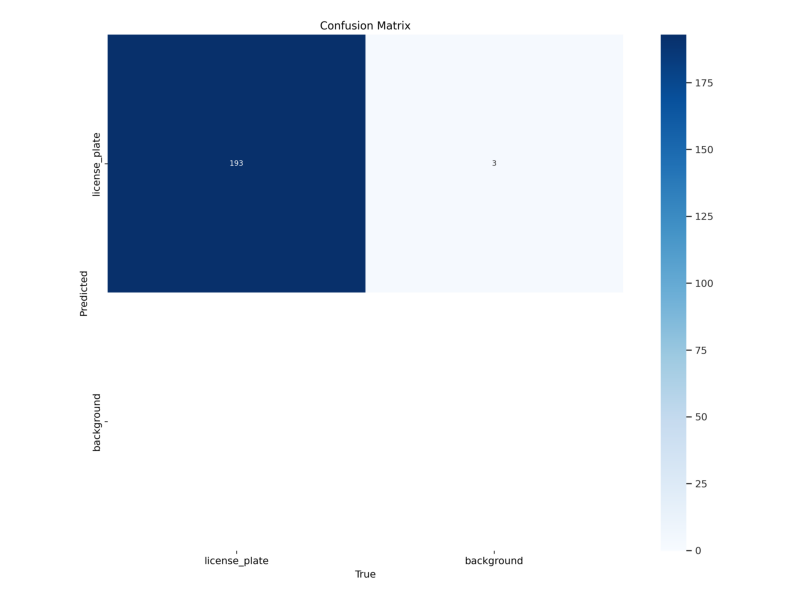

In [ ]:


fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("/content/runs/detect/val2/confusion_matrix.png")
plt.imshow(cm_img)
plt.axis("off")
fig.show()



Text(0.55, 0.93, 'Testing Curve')

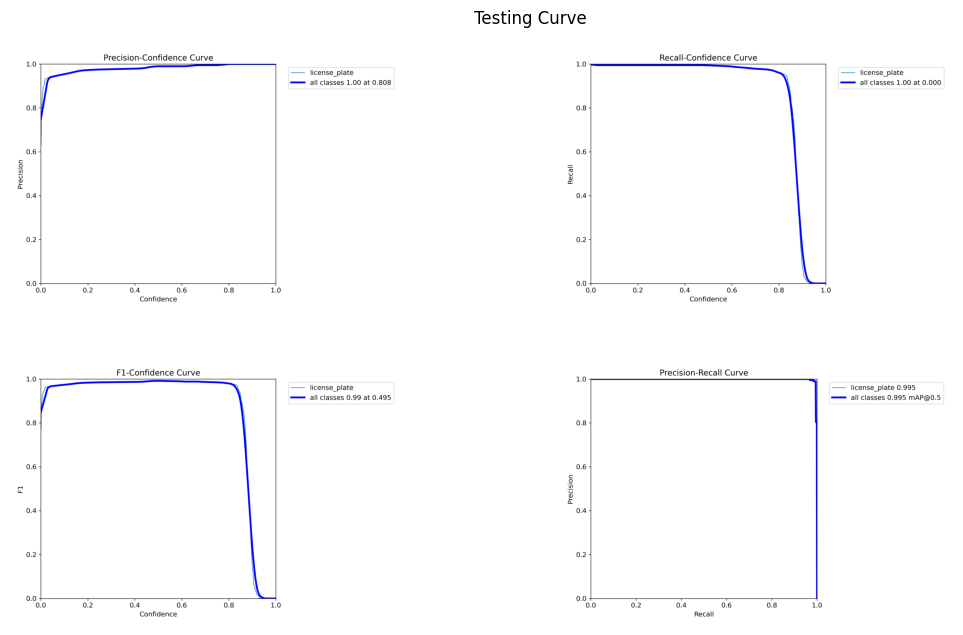

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/content/runs/detect/val2/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')

# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show

In [ ]:
df_results = df_test[["filename", "plate_number", "xmin", "ymin", "xmax", "ymax"]]
df_results = df_results.rename(columns={"filename": "image_path", "xmin": "x1_bbox", "ymin": "y1_bbox", "xmax": "x2_bbox", "ymax": "y2_bbox"})
df_results = df_results.reset_index(drop=True)
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,/content/google_images/4ed4509a-18ed-44cd-bfe3...,TN21AT0480,285,322,490,375
1,/content/google_images/4b669e6d-4eec-4f46-b502...,MH14TC206AN,138,54,436,163
2,/content/State-wise_OLX/PY/PY6.jpg,PY01AP0555,93,262,182,281
3,/content/State-wise_OLX/HR/HR22.jpg,HR09G8378,74,215,136,233
4,/content/State-wise_OLX/MP/MP6.jpg,MP07CA5563,91,239,178,256
...,...,...,...,...,...,...
188,/content/State-wise_OLX/CG/CG15.jpg,CG07BR3255,109,130,166,142
189,/content/State-wise_OLX/PB/PB23.jpg,PB02CC7299,122,112,163,123
190,/content/google_images/6cd15e75-3e26-41f2-a6aa...,MH14EY5972,18,246,89,312
191,/content/State-wise_OLX/PY/PY1.jpg,PY01Q7947,97,282,172,299


In [ ]:


# Get Bounding Box Predictions
from ultralytics import YOLO

yolo_model = YOLO('/content/runs/detect/train12/weights/best.pt')
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []
for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)



In [ ]:
df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,/content/google_images/4ed4509a-18ed-44cd-bfe3...,TN21AT0480,285,322,490,375,"[[285, 319, 490, 372]]",[0.89]
1,/content/google_images/4b669e6d-4eec-4f46-b502...,MH14TC206AN,138,54,436,163,"[[142, 57, 425, 168]]",[0.58]
2,/content/State-wise_OLX/PY/PY6.jpg,PY01AP0555,93,262,182,281,"[[92, 262, 183, 281]]",[0.87]
3,/content/State-wise_OLX/HR/HR22.jpg,HR09G8378,74,215,136,233,"[[74, 215, 135, 232]]",[0.88]
4,/content/State-wise_OLX/MP/MP6.jpg,MP07CA5563,91,239,178,256,"[[90, 239, 178, 256]]",[0.85]
...,...,...,...,...,...,...,...,...
188,/content/State-wise_OLX/CG/CG15.jpg,CG07BR3255,109,130,166,142,"[[109, 128, 166, 142]]",[0.86]
189,/content/State-wise_OLX/PB/PB23.jpg,PB02CC7299,122,112,163,123,"[[121, 111, 163, 123]]",[0.84]
190,/content/google_images/6cd15e75-3e26-41f2-a6aa...,MH14EY5972,18,246,89,312,"[[19, 251, 89, 311]]",[0.87]
191,/content/State-wise_OLX/PY/PY1.jpg,PY01Q7947,97,282,172,299,"[[96, 282, 173, 299]]",[0.87]


/content/google_images/4b669e6d-4eec-4f46-b502-f64ee0175947___new_1.jpg


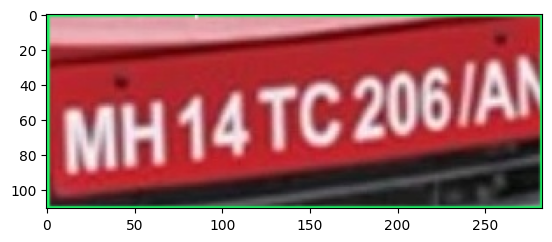

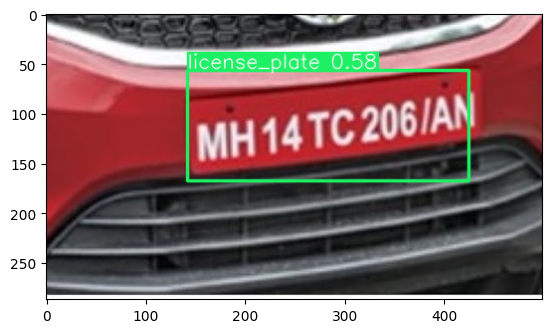

/content/State-wise_OLX/PY/PY6.jpg


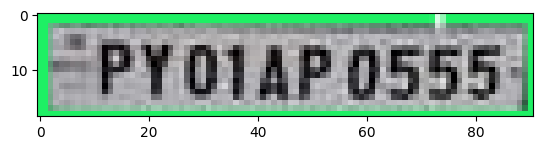

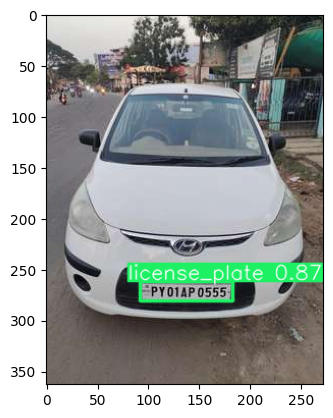

/content/State-wise_OLX/HR/HR22.jpg


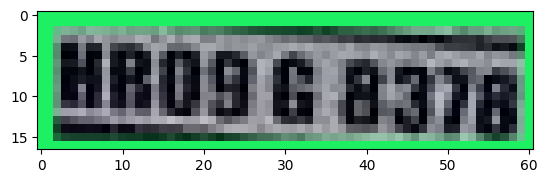

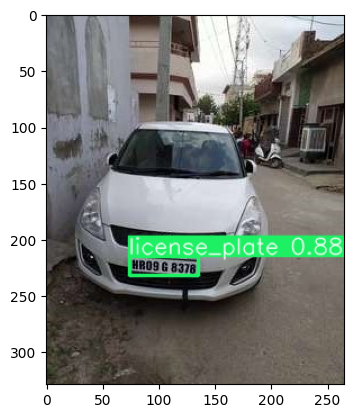

/content/State-wise_OLX/MP/MP6.jpg


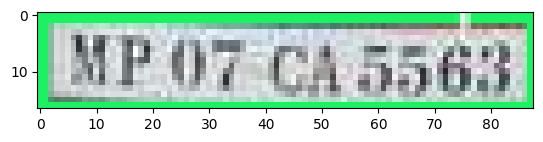

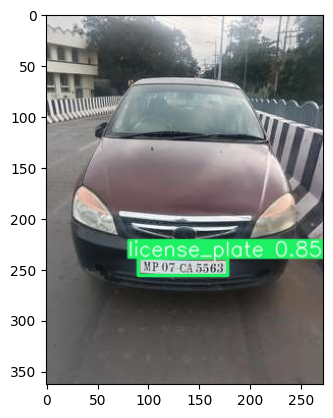

/content/google_images/07f6d77a-652e-4885-8520-6d405d2f712f___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_840539077_1_1080x720_nissan-terrano-xl-d-thp-110-ps-2016-diesel-.jpg


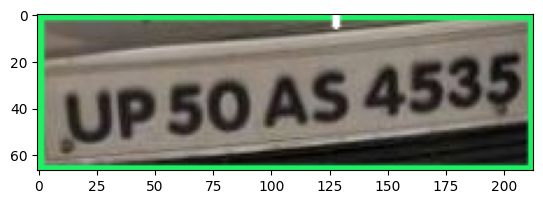

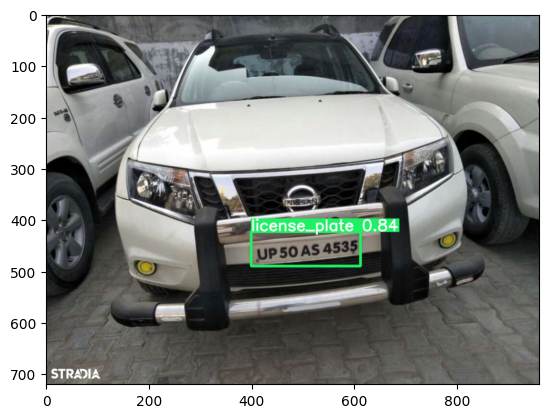

In [ ]:
##to check if image has license plate or not, after this OCR scan will be done to find out the exact plate no.

from ultralytics.utils.plotting import Annotator

def show_plate_detection(idx):
    # Original Image
    ori_path = df_results["image_path"][idx]
    print(ori_path)
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    # Annotate Box
    annotator = Annotator(ori_image)
    boxes = df_results["pred_bbox"][idx]
    confs = df_results["confidence"][idx]
    for i, box in enumerate(boxes):
        annotator.box_label(box=box, label="license_plate " + (str(confs[i])), color=(30, 240, 100))

        # Get Plate Object
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = ori_image[y1:y2, x1:x2]
        plt.imshow(roi)
        plt.show()

    # Show Image
    frame = annotator.result()
    plt.imshow(frame)
    plt.show()

idxs = [1, 2, 3, 4, 5]
for idx in idxs:
    show_plate_detection(idx)



In [ ]:
import cv2

# Khởi tạo VideoCapture để đọc video từ webcam hoặc tệp video
cap = cv2.VideoCapture(0)  # Sử dụng 0 để đọc từ webcam, hoặc đường dẫn đến tệp video

while True:
    # Đọc frame từ video
    ret, frame = cap.read()

    if not ret:
        break

    # Tọa độ của hai ô vuông
    x1_oto = 100
    y1_oto = 100
    x2_oto = x1_oto + 200
    y2_oto = y1_oto + 150

    x1_onho = 400
    y1_onho = 100
    x2_onho = x1_onho + 100
    y2_onho = y1_onho + 75

    # Vẽ hai ô vuông lên frame
    cv2.rectangle(frame, (x1_oto, y1_oto), (x2_oto, y2_oto), (0, 255, 0), 2)
    cv2.rectangle(frame, (x1_onho, y1_onho), (x2_onho, y2_onho), (0, 0, 255), 2)

    # Ghi text lên trên ô vuông
    cv2.putText(frame, "ô tô", (x1_oto, y1_oto - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(frame, "ô nhỏ", (x1_onho, y1_onho - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Hiển thị frame bằng imshow
    cv2.imshow("Video", frame)

    # Thoát nếu nhấn phím 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng VideoCapture và đóng cửa sổ imshow
cap.release()
cv2.destroyAllWindows()

In [ ]:
!pip install opencv-python pytesseract

In [ ]:
import cv2
import pytesseract
import numpy as np

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/train12/weights/best.pt')  # Đường dẫn đến file trọng số của mô hình

In [ ]:
img_path = 'path/to/your/image.jpg'  # Thay thế bằng đường dẫn đến ảnh của bạn
img = cv2.imread(img_path)

In [ ]:
results = model.predict(img_path)  # Chạy inference
boxes = results[0].boxes  # Lấy bounding box của biển số

In [ ]:
for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()  # Tọa độ bounding box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    plate_img = img[y1:y2, x1:x2]  # Cắt vùng biển số

    # Thực hiện OCR bằng Tesseract
    plate_text = pytesseract.image_to_string(plate_img, config='--psm 11')
    print("Biển số:", plate_text)

    # Ghi text lên ảnh
    cv2.putText(img, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

In [ ]:
output_path = 'path/to/save/output.jpg'  # Đường dẫn để lưu ảnh đầu ra
cv2.imwrite(output_path, img)